# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Vehicle Detection and Tracking


---
## Step 0: Load The Data

In [1]:
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_dir_path = []

vehicle_dir_path.append('vehicles/vehicles/KITTI_extracted/')

non_vehicle_dir_path = []

non_vehicle_dir_path.append('non-vehicles/non-vehicles/Extras/')

vehicle_images = []
non_vehicle_images = []

for i in range(len(vehicle_dir_path)):
    dir_path = vehicle_dir_path[i]
    vehicle_files = os.listdir(dir_path)
    for file in vehicle_files:    
        # Define the image path
        file_path = dir_path + file    
        # read image
        image = mpimg.imread(file_path)
        vehicle_images.append(image)
    
for i in range(len(non_vehicle_dir_path)):
    dir_path = non_vehicle_dir_path[i]
    non_vehicle_files = os.listdir(dir_path)    
    for file in non_vehicle_files:    
        # Define the image path
        file_path = dir_path + file    
        # read image
        image = mpimg.imread(file_path)
        non_vehicle_images.append(image)

vehicle_labels = [1]*len(vehicle_images)
non_vehicle_labels = [0]*len(non_vehicle_images)

Data = np.concatenate((vehicle_images,non_vehicle_images))
labels = np.concatenate((vehicle_labels, non_vehicle_labels))

### Test Data

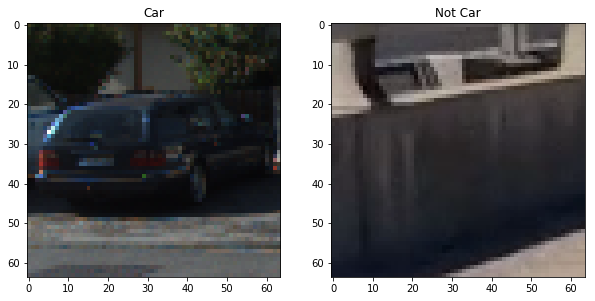

In [59]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

index = random.randint(0,len(vehicle_images))
vehicle_image = vehicle_images[index]
plt.subplot(1,2,1)
plt.title('Car')
plt.imshow(vehicle_image)

index = random.randint(0,len(non_vehicle_images))
non_vehicle_image = non_vehicle_images[index]
plt.subplot(1,2,2)
plt.title('Not Car')
plt.imshow(non_vehicle_image)
plt.savefig('output_images/Vehicle_and_Non_Vehicle',bbox_inches='tight')

plt.show()


### Split data into training, validation and testing data

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Data, labels = shuffle(Data, labels)

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, random_state=rand_state)


---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

In [3]:
n_train = X_train.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of Vehicle Examples =", len(vehicle_images))
print("Number of Not Vehicle Examples =", len(non_vehicle_images))

Number of training examples = 8827
Number of testing examples = 2207
Image data shape = (64, 64, 3)
Number of Vehicle Examples = 5966
Number of Not Vehicle Examples = 5068


---
## Histogram Of Oriented Gradient

### Image Color Histogram and Oriented Gradient Histogram

In [4]:
from skimage.feature import hog

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


### Extract Image Features

In [5]:
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    img = np.copy(image)
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    
    #print(np.min(np.min(feature_image)),np.max(np.max(feature_image)))
    #feature_image = feature_image - 0.5
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)


def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):    
    features = []
    # Iterate through the list of images
    for image in images:
        img_features = single_img_features(image, color_space, spatial_size,
                                           hist_bins, orient, pix_per_cell, cell_per_block, 
                                           hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(img_features)
        
    return features

In [46]:
from sklearn.preprocessing import StandardScaler

color_space = 'YCrCb'
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


X_train_features = extract_features(X_train, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)

X_test_features = extract_features(X_test, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X_scaler_train = StandardScaler().fit(X_train_features)
X_train_scaler = X_scaler_train.transform(X_train_features)

X_scaler_test = StandardScaler().fit(X_test_features)
X_test_scaler = X_scaler_test.transform(X_test_features)


### Train and Test the Classifier

In [47]:
from sklearn import svm, grid_search
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

Classifier_Status = 'Save'

if Classifier_Status == 'Save':
    #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    #svc = svm.SVC()
    #clf = grid_search.GridSearchCV(svc, parameters)
    clf = svm.SVC(kernel = 'rbf', C = 1.0)
    clf.fit(X_train_scaler, y_train)
    joblib.dump(clf, 'Classifier.joblib.pkl')  
elif Classifier_Status == 'Load':
    clf = joblib.load('Classifier.joblib.pkl')
        
print('Test Accuracy of SVC = ', round(clf.score(X_test_scaler, y_test), 4))

Test Accuracy of SVC =  0.9995


---

## Detect Vehicles in images

After training the classifier, we are ready to use it in images to detect vehicles. We create sliding windows over the image and pass these windows to the classifier to predict the window class.

1. Prepare test images
2. Detect Vehicles in test images
3. Remove Flase Positives 

### 1. Prepare Test Images

In [48]:
test_dir_path = 'test_images/'
output_dir_path = 'output_images/'

test_files = os.listdir(test_dir_path)

test_images = []
    
for file in test_files:    
    # Define the image path
    file_path = test_dir_path + file
    # read image
    image = mpimg.imread(file_path)
    #image = np.float32(image/255.0)
    test_images.append(image)



### 2. Detect Vehicles in test images

In [49]:
import matplotlib.pyplot as plt

def draw_boxes(img, bboxes, color = (0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop == [None,None]:
        x_start_stop = [0,img.shape[1]]
    if y_start_stop == [None,None]:
        y_start_stop = [0,img.shape[0]]

    n_x = int((x_start_stop[1] - x_start_stop[0])/(xy_window[0]*xy_overlap[0])) - 1
    n_y = int((y_start_stop[1] - y_start_stop[0])/(xy_window[1]*xy_overlap[1])) - 1
    
    window_list = []
    # Loop through finding x and y window positions
    for xi in range(n_x):
        for yi in range(n_y):
            x_start = x_start_stop[0] + int(xi*(xy_window[0]*xy_overlap[0]))
            y_start = y_start_stop[0] + int(yi*(xy_window[1]*xy_overlap[1]))
            x_end = x_start + xy_window[0]
            y_end = y_start + xy_window[1]
            window_list.append(((x_start,y_start),(x_end, y_end)))
            
    return window_list


In [57]:
def Test_Sliding_Window(img):
    windows = []
    
    draw_image = np.copy(image)
    
    for i in range(5,8): 
        windows_boundary = slide_window(draw_image, 
                                        x_start_stop=[None, None], 
                                        y_start_stop=[int(image.shape[0]*0.5), int(image.shape[0]*0.85)], 
                                        xy_window=(32*i, 32*i), 
                                        xy_overlap=(0.25, 0.25))
        windows += windows_boundary
    
    window_img = draw_boxes(draw_image, 
                            windows, 
                            color=(0, 0, 1), 
                            thick=6) 
        
    return window_img
    

### Test Sliding Windows

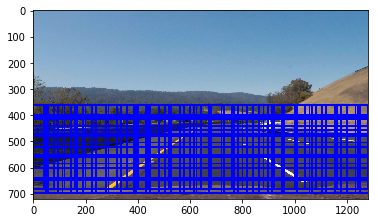

In [58]:
import random
import matplotlib.pyplot as plt

index = random.randint(0,len(test_images))
output_img = Test_Sliding_Window(test_images[index])
plt.imshow(output_img)
    
plt.savefig(output_dir_path + 'Test_Sliding_Windows.png',bbox_inches='tight')
plt.show()


### Detect Vehicles in test images

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space, spatial_size,
                                       hist_bins, orient, pix_per_cell, cell_per_block, 
                                       hog_channel, spatial_feat, hist_feat, hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows  

def Vehicle_Detection(image):
    
    windows = []
    
    draw_image = np.copy(image)
    
    for i in range(2,8): 
        windows_boundary = slide_window(draw_image, 
                                        x_start_stop=[None, None], 
                                        y_start_stop=[int(image.shape[0]*0.5), int(image.shape[0]*0.85)], 
                                        xy_window=(32*i, 32*i), 
                                        xy_overlap=(0.25, 0.25))
        windows += windows_boundary
        
        hot_windows = search_windows(draw_image, windows, clf, X_scaler_train, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat)  
            
        window_img = draw_boxes(image, 
                                hot_windows, 
                                color=(0, 0, 1), 
                                thick=6) 
        
    return window_img

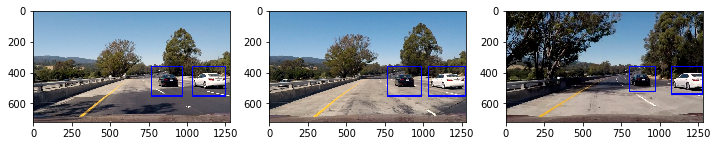

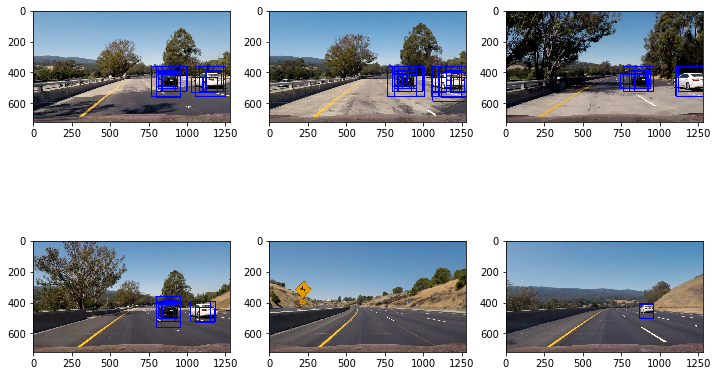

In [73]:
plt.figure(figsize=(12, 12))

for i in range(len(test_images)):
    output_img = Vehicle_Detection(test_images[i])
    plt.subplot(int(len(test_images)/3) + 1,3,i+1)
    plt.imshow(output_img)
    
plt.savefig(output_dir_path + 'Vehicle_Detection.png',bbox_inches='tight')
plt.show()

### 3. Remove False Positives & Define Bounding Boxes

In [11]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, windows):
    # Iterate through list of bboxes
    for window in windows:

        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels,color,thick):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image
    return img

def Vehicle_Detection_Heat_Map(image):
    
    windows = []
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_image = np.copy(image)
    
    for i in range(2,8):
        windows_boundary = slide_window(draw_image, 
                                        x_start_stop=[None, None], 
                                        y_start_stop=[int(image.shape[0]*0.5), int(image.shape[0]*0.85)], 
                                        xy_window=(32*i, 32*i), 
                                        xy_overlap=(0.2, 0.2))
        windows += windows_boundary

    hot_windows = search_windows(draw_image, windows, clf, X_scaler_train, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)            
    
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    #window_img = draw_boxes(image, 
    #                        hot_windows, 
    #                        color=(0, 0, 255), 
    #                        thick=6)  
    
    heat_img = draw_labeled_bboxes(draw_image, labels,(0,0,1),6)
    return heat_img


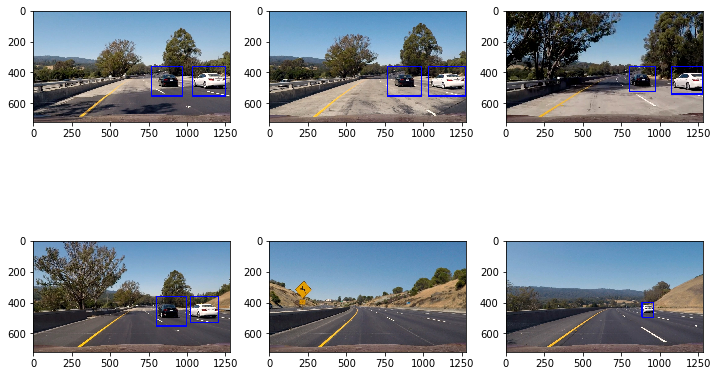

In [75]:
plt.figure(figsize=(12, 12))
for i in range(len(test_images)):
    output_img = Vehicle_Detection_Heat_Map(test_images[i])
    plt.subplot(int(len(test_images)/3) + 1,3,i+1)
    plt.imshow(output_img)
    
#plt.savefig(output_dir_path + test_files[i])
plt.savefig(output_dir_path + 'Remove_False_Positive.png',bbox_inches='tight')
plt.show()

---
## Detect & Track Vehicles in Video

I used the positive detections in batches of consecutive frames to create a heatmap which was thresholded to get rid of all false positives.
Here I will use 5 consecutive frames from the video to show the heatmap accumulation and the final result.

In [42]:
heatmaps = []
accum_heat_map_img = None
output_image = None
nb_frames_avg = 5

def Heat_Map_Video_Test(frame):
        
    windows = []
    heatmap = np.zeros((frame.shape[0],frame.shape[1]))
    draw_image = np.float32(frame/255.0)
        
    for i in range(2,8):
        window_boundary = slide_window(draw_image, x_start_stop=[None, None], 
                                    y_start_stop=[int(draw_image.shape[0]*0.5), int(draw_image.shape[0]*0.85)], 
                                    xy_window=(32*i, 32*i), xy_overlap=(0.25, 0.25))
        windows += window_boundary

    hot_windows = search_windows(draw_image, windows, clf, X_scaler_train, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)   
    
    window_img = draw_boxes(draw_image, 
                            hot_windows, 
                            color=(0, 0, 1), 
                            thick=6)     
        
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 1)
    heatmaps.append(heatmap)

    if(len(heatmaps) > nb_frames_avg):
        heatmaps.pop(0)
        
    accum_heat_map = sum(heatmaps)

    threshold_heat_map = apply_threshold(accum_heat_map, 2)
    threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

    labels = label(threshold_heat_map)

    output_frame = draw_labeled_bboxes(frame,labels,(0,0,255),6)
        
    return window_img, heatmap, accum_heat_map, output_frame

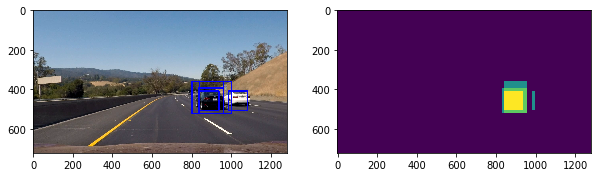

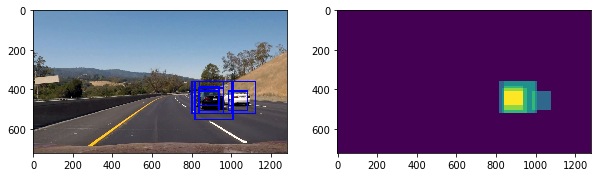

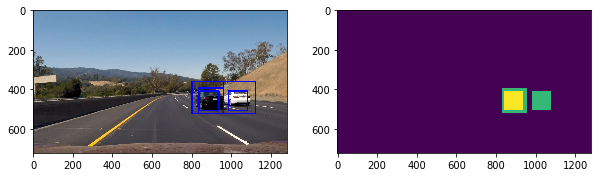

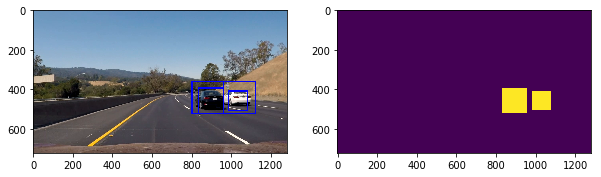

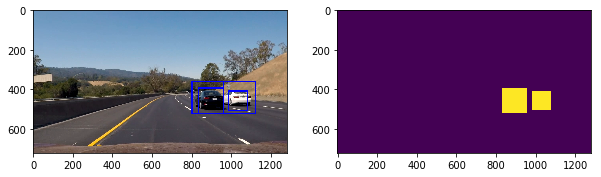

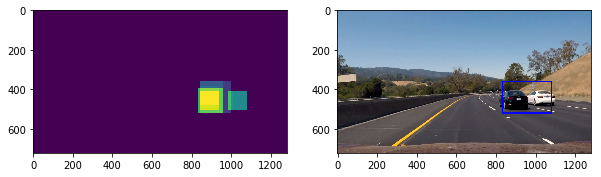

In [43]:
import imageio

filename = 'project_video.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
nums = range(900, 905)
for idx in range(len(nums)):
    image = vid.get_data(nums[idx])
    window_img, heatmap_img, accum_heat_map_img, output_img = Heat_Map_Video_Test(image)
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.imshow(window_img)
    plt.subplot(1,2,2)
    plt.imshow(heatmap_img)
    plt.savefig('test_images/Video_Test_Heat_map'+str(idx+1)+'.png',bbox_inches='tight')
    
plt.savefig('test_images/Video_Test_Heat_map.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(accum_heat_map_img)
plt.subplot(1,2,2)
plt.imshow(output_img)
plt.savefig('test_images/Video_Test_Output.png',bbox_inches='tight')
plt.show()


### Process Project Video

In [76]:
class VehicleTracker:
    
    def __init__(self, frame_size = (720,1280)):
        self.frame_size = frame_size
        self.frames = []
        self.heatmaps = []
        self.current_frame = 0

    def process_frame(self, frame):

        windows = []
        heatmap = np.zeros(self.frame_size)
        draw_image = np.float32(frame/255.0)
        
        if(self.current_frame < nb_frames_avg):
            self.current_frame += 1
        
        for i in range(2,8):
            window_boundary = slide_window(draw_image, x_start_stop=[None, None], 
                                    y_start_stop=[int(draw_image.shape[0]*0.5), int(draw_image.shape[0]*0.85)], 
                                    xy_window=(32*i, 32*i), xy_overlap=(0.25, 0.25))
            windows += window_boundary

        hot_windows = search_windows(draw_image, windows, clf, X_scaler_train, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat)            
     
        heatmap = add_heat(heatmap, hot_windows)
        heatmap = apply_threshold(heatmap, 1)
        self.heatmaps.append(heatmap)

        if(len(self.heatmaps) > nb_frames_avg):
            self.heatmaps.pop(0)
        
        accum_heat_map = sum(self.heatmaps)

        threshold_heat_map = apply_threshold(accum_heat_map, 2)
        threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

        labels = label(threshold_heat_map)
        
        output_frame = draw_labeled_bboxes(frame,labels,(0,0,255),6)
        
        return output_frame


In [ ]:
del VT
del clip1
del project_clip

In [16]:
VT = VehicleTracker()

project_output = 'project_video_output_All.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(25,40)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(VT.process_frame) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output_All.mp4
[MoviePy] Writing video project_video_output_All.mp4


100%|█████████▉| 1260/1261 [17:57:07<00:51, 51.37s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_All.mp4 

CPU times: user 17h 56min 51s, sys: 12.7 s, total: 17h 57min 3s
Wall time: 17h 57min 8s
